In [5]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipw
import bqplot as bq
%matplotlib inline

# 1D RTE: Full v.s. Asymptotics

I'm having trouble understanding how to deal with discrete angles in the 3D asymptotics, so I'm returning to the simplest case.

Two angles: +/- (down/up)

Assume absorption ($a$) and scattering ($b$) coeffiecients are constant over space.

### RTE:
\begin{align}
    \frac{dL^+}{dz} &= -(a+b) L^+ + bL^- \\
    \frac{dL^-}{dz} &= bL^+ - (a+b)L^-
\end{align}
  
### BC:
\begin{align}
    L^+(0) &= I_0 \\
    L^-(M) &= 0
\end{align}

## Define parameters

In [169]:
I0 = 1
M = 1
a = 2
b = 1

### Numerical parameters

In [177]:
dz = 5e-2
z = np.arange(0,M+dz,dz)

## Full Solution

In [178]:
s = a/b + 1
q = np.sqrt(a**2+2*a*b)/b

c2 = -I0 / ((s-q)/(s+q)*np.exp(-2*b*q*M) - 1)
c1 = I0 - c2

# Downward
Lp = c1*np.exp(b*q*z) + c2*np.exp(-b*q*z)
# Upward
Lm = c1*(s+q)*np.exp(b*q*z) + c2*(s-q)*np.exp(-b*q*z)

## Symbolic Asymptotics

In [179]:
L0p = np.exp(-a*z)
L0m = 0*z

#L1p = np.exp(-a*z) * (I0 + 1/(2*a) * (np.exp(-2*a*z)-1))
#L1m = -(z-M) * np.exp(a*(z-2*M))
L1p = -z*np.exp(-a*z)
L1m = (M-z)*np.exp(-a*z)

In [207]:
trap_rule([0], [1])

0.0

# Numerical Asymptotics

In [214]:
def trap_rule(x,y):
    return np.sum((y[1:] + y[:-1])*np.diff(x)/2)

def scatter(z, a, b, I0, M, n):
    # 0th order (no scattering)
    L0p = np.exp(-a*z)
    L0m = 0*z
    
    # i terms
    Lip = L0p
    Lim = L0m
    
    # Final results
    Lp = L0p
    Lm = L0m
    for i in range(1,n+1):
        # Calculate source
        Sip = -(Lip - Lim)
        Sim =  (Lip - Lim)
        
        # Calculate order i+1 scatter term
        Lip1p = np.zeros_like(z)
        Lip1m = np.zeros_like(z)
        for k in range(len(z)):
            zp = z[:k+1]
            Lip1p[k] = trap_rule(zp, Sip[:k+1]*np.exp(a*(zp-z[k])))
            
            zp = z[k:]
            Lip1m[k] = trap_rule(zp, Sim[k:]*np.exp(a*(z[k]-zp)))
       
        Lip = Lip1p
        Lim = Lip1m
        
        Lp += b**i * Lip
        Lm += b**i * Lim
    
    return Lp, Lm

In [215]:
Lps, Lms = scatter(z, a, b, I0, M, 2)

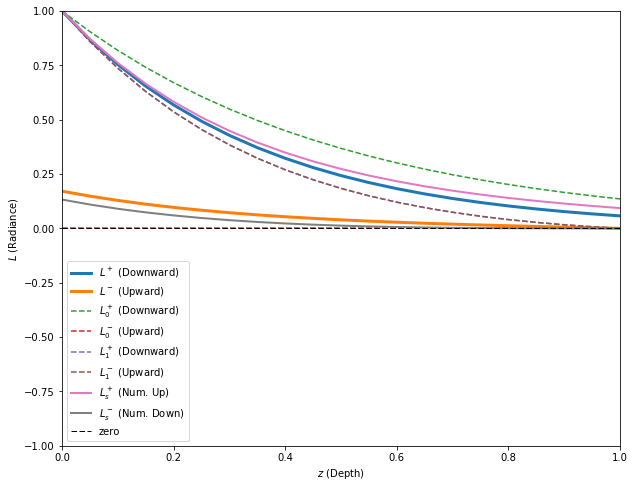

In [219]:
plt.figure(figsize=[10,8])
plt.plot(z, Lp, label='$L^+$ (Downward)', lw=3)
plt.plot(z, Lm, label='$L^-$ (Upward)', lw=3)
plt.plot(z, L0p, '--', label='$L_0^+$ (Downward)')
plt.plot(z, L0m, '--', label='$L_0^-$ (Upward)')
plt.plot(z, L0p+b*L1p, '--', label='$L_1^+$ (Downward)')
plt.plot(z, L0m+b*L1m, '--', label='$L_1^-$ (Upward)')
plt.plot(z, Lps, label='$L_s^+$ (Num. Up)', lw=2)
plt.plot(z, Lms, label='$L_s^-$ (Num. Down)', lw=2)
plt.plot(z,z*0, 'k--', lw=1, label='zero')
plt.xlabel('$z$ (Depth)')
plt.ylabel('$L$ (Radiance)')
plt.xlim(0, M)
plt.ylim(-I0, I0)
plt.legend()

## Check solution

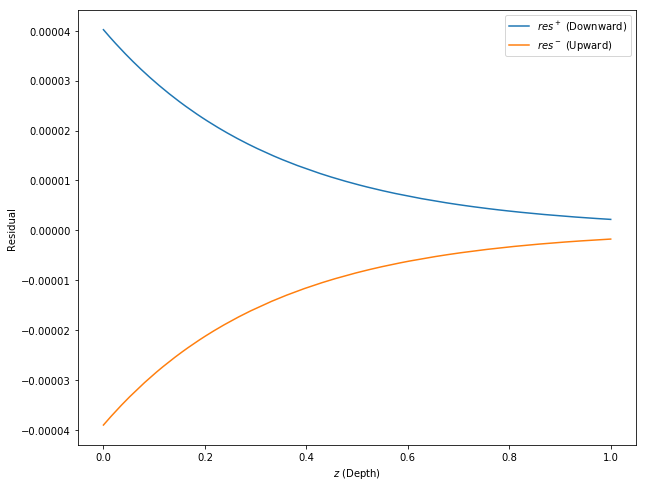

In [31]:
dLp = np.diff(Lp)/dz
dLm = np.diff(Lm)/dz

res_p = dLp + (a+b)*Lp[:-1] - b*Lm[:-1]
res_m = dLm - b*Lp[:-1] + (a+b)*Lm[:-1]

plt.figure(figsize=[10,8])
plt.plot(z[:-1], res_p, label='$res^+$ (Downward)')
plt.plot(z[:-1], res_m, label='$res^-$ (Upward)')
plt.xlabel('$z$ (Depth)')
plt.ylabel('Residual')
plt.legend()

For dz=1e-4, both residuals have absolute value < 1e-5., so we have a solution to the equation.

**Since the upward solution is negative, the equation must be incorrect.**

## Try with different boundary conditions:
\begin{align}
    L^+(0) = I_0 \\
    L^-(0) = I_1
\end{align}

In [32]:
I1 = .5

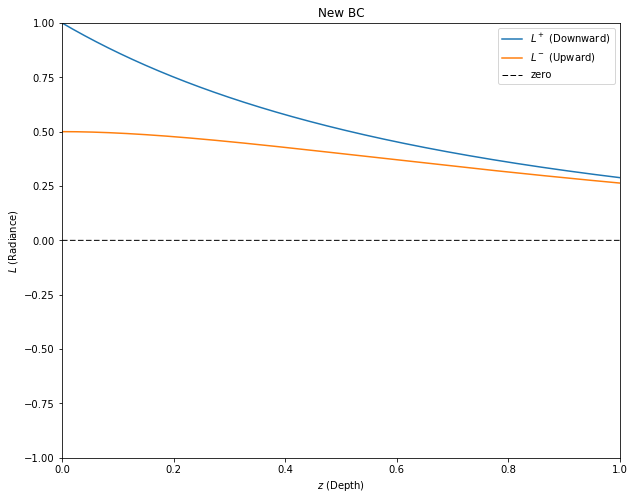

In [33]:
c1_newbc = (I0 + I1) / 2
c2_newbc = (I0 - I1) / 2

# Downward
Lp_newbc = c1_newbc*np.exp(-a*z) + c2_newbc*np.exp(-(a+2*b)*z)
# Upward
Lm_newbc = c1_newbc*np.exp(-a*z) - c2_newbc*np.exp(-(a+2*b)*z)

plt.figure(figsize=[10,8])
plt.plot(z, Lp_newbc, label='$L^+$ (Downward)')
plt.plot(z, Lm_newbc, label='$L^-$ (Upward)')
plt.plot(z,z*0, 'k--', lw=1, label='zero')
plt.xlabel('$z$ (Depth)')
plt.ylabel('$L$ (Radiance)')
plt.xlim(0, M)
plt.ylim(-I0, I0)
plt.title("New BC")
plt.legend()

**So 